In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_base_dir = '../../../datasets/Movielens/'
data_dir = data_base_dir + 'serendipity-sac2018/'
data_dir2 = data_base_dir + 'ml-20m/'
output_dir = data_dir + 'output/'

genome_scores = data_dir + 'genome_scores.csv'
# genome_tags = data_dir + 'genome-tags.csv'
movies = data_dir + 'movies.csv'
# ratings = data_dir + 'ratings.csv'
ratings = data_dir + 'training.csv'
# tags = data_dir + 'tags.csv'
answers = data_dir + 'answers.csv'
genre_binary_terms = output_dir + 'movie_genre_binary_term_vector_df_bz2'
movies_lemmatized = output_dir + 'movies_lemmatized_genome_vector_df_bz2'

ratings_df = pd.read_csv(ratings)
ratings_df

,userId,movieId,rating,timestamp
0,142882,91658,2.5,1515209647000
1,142882,4344,1.0,1515209646000
2,142882,45720,2.0,1515209643000
3,142882,4734,2.0,1515209641000
4,142882,91542,2.0,1515209637000
5,142882,4446,1.5,1515209635000
6,142882,3354,2.5,1515209632000
7,142882,4701,1.0,1515209631000
8,142882,31696,0.5,1515209629000
9,142882,97921,2.0,1515209625000


In [2]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_absolute_error

class ContentBased_Recommender:
    def __init__(self, term_vector_df, ratings_df, K=5, metric='cosine'):
        self.term_vector_df = term_vector_df
        self.K = K
        self.ratings_df = ratings_df.loc[:, ['rating', 'movieId']].groupby('movieId').mean()['rating']
        self.movie_movie_distances = pd.DataFrame(pairwise_distances(self.term_vector_df, metric=metric), index=self.term_vector_df.index, columns=self.term_vector_df.index)
        
    def recommend_similar_movies(self, movie_id, K=None):
        if K is None:
            K = self.K
            
        sorted_values = self.movie_movie_distances.loc[:, movie_id].sort_values(ascending=False)
        
        recommendations = sorted_values.index.values[:K]
        distances = sorted_values.values[:K]
        return recommendations, distances
    
    def get_mae_for_prediction(self, movie_id, K=None, weighted=False):
        if K is None:
            K = self.K
            
        recommendations, distances = self.recommend_similar_movies(movie_id, K)
        k_nearest_ratings = self.ratings_df[recommendations].values
        
        if weighted:
            predicted = np.sum(distances * k_nearest_ratings) / np.sum(distances)
        else:
            predicted = np.sum(k_nearest_ratings) / len(k_nearest_ratings)
            
        actual = self.ratings_df[movie_id]
        
        return mean_absolute_error([actual], [predicted])

In [3]:
l1 ='movies_lemmatized_threshold_'
l2 = '_float_movie_genomes_bz2'

# threshold_0.2_float_movie_genomes_bz2
l3 = 'threshold_'
l4 = '_float_movie_genomes_bz2'
thresholds = [0.2, 0.25, 0.3, 0.35, 0.4, 0.6, 0.7]

lemmatized_labels = [(l1 + str(x) + l2) for x in thresholds]
lemmatized_labels

full_labels = [(l3 + str(x) + l4) for x in thresholds]
full_labels

['threshold_0.2_float_movie_genomes_bz2',
 'threshold_0.25_float_movie_genomes_bz2',
 'threshold_0.3_float_movie_genomes_bz2',
 'threshold_0.35_float_movie_genomes_bz2',
 'threshold_0.4_float_movie_genomes_bz2',
 'threshold_0.6_float_movie_genomes_bz2',
 'threshold_0.7_float_movie_genomes_bz2']

In [4]:
user_full_genome_terms_df = pd.read_pickle(output_dir + 'user_full_genome_terms_df_bz2', compression='bz2')
user_full_genome_terms_gzip_df = pd.read_pickle(output_dir + 'user_full_genome_terms_df_gzip', compression='bz2')

lemmatized_thresholded_dfs = list()
full_thresholded_dfs = list()

for i, t in enumerate(thresholds):
    lemmatized_thresholded_dfs.append(pd.read_pickle(output_dir + lemmatized_labels[i], compression='bz2'))
    full_thresholded_dfs.append(pd.read_pickle(output_dir + lemmatized_labels[i], compression='bz2'))

In [5]:
# load term vectors
genre_binary_terms_df = pd.read_pickle(genre_binary_terms, compression='bz2')
movies_lemmatized_df = pd.read_pickle(movies_lemmatized, compression='bz2')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


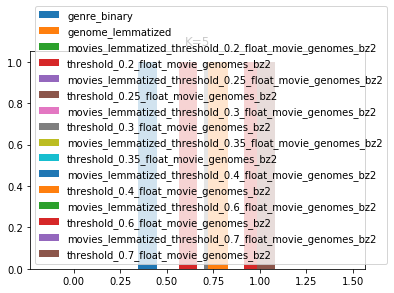

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


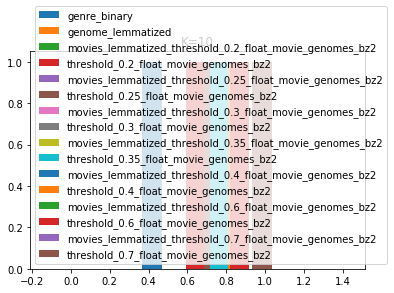

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


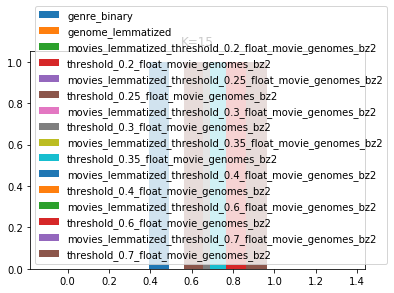

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


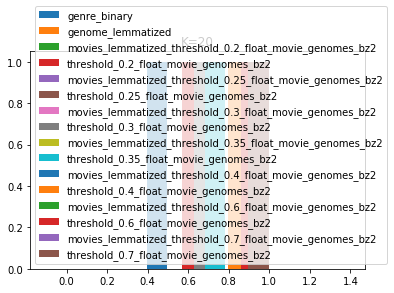

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


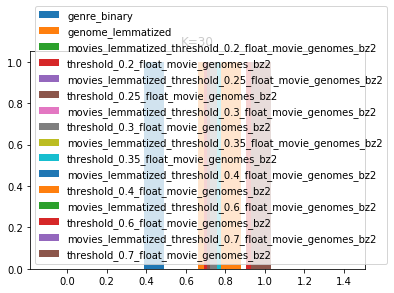

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


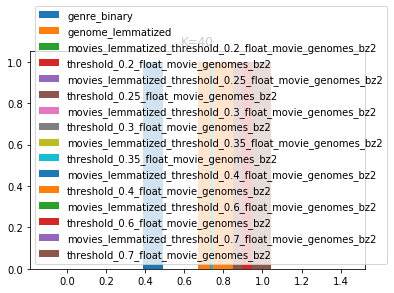

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


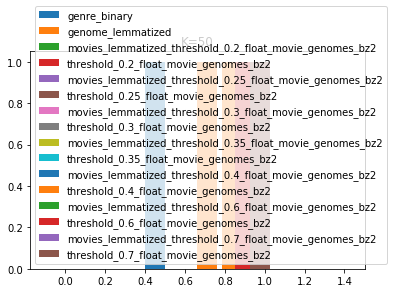

In [140]:
import matplotlib.pyplot as plt

labels = ['genre_binary', 'genome_lemmatized']
all_movie_ids = genre_binary_terms_df.index.values

for index, K in enumerate([5, 10, 15, 20, 30, 40, 50]):
    genre_recommender = ContentBased_Recommender(genre_binary_terms_df, ratings_df, K, 'jaccard')
    genome_recommender = ContentBased_Recommender(movies_lemmatized_df, ratings_df, K, 'cosine')
    
    lemmatized_recommenders = list()
    full_recommenders = list()
    for i, t in enumerate(thresholds):
        lemmatized_recommenders.append(ContentBased_Recommender(lemmatized_thresholded_dfs[i], ratings_df, K))
        full_recommenders.append(ContentBased_Recommender(full_thresholded_dfs[i], ratings_df, K))
        
    genre_mae_list = list()
    genome_mae_list = list()
    lemmatized_mae_list = list()
    full_mae_list = list()

    for movie_id in all_movie_ids[:]:
        genre_mae_list.append(genre_recommender.get_mae_for_prediction(movie_id, K))
        genome_mae_list.append(genome_recommender.get_mae_for_prediction(movie_id, K))
        
        for i, t in enumerate(thresholds):
            lemmatized_mae_list.append(lemmatized_recommenders[i].get_mae_for_prediction(movie_id, K))
            full_mae_list.append(full_recommenders[i].get_mae_for_prediction(movie_id, K))
        
#     plt.subplot(4, 2, (index + 1))
#     plt.figsize(15, 15)
    plt.title('K=' + str(K))
#     plt.hist(np.array(genre_mae_list).mean())
#     plt.hist(np.array(genome_mae_list).mean())
    plt.hist(np.median(genre_mae_list))
    plt.hist(np.median(genome_mae_list))
    
    for i, t in enumerate(thresholds):
        plt.hist(np.median(lemmatized_mae_list[i]))
        plt.hist(np.median(full_mae_list[i]))
        
        labels.append(lemmatized_labels[i])
        labels.append(full_labels[i])
    
    plt.legend(labels)
    plt.show()